### Task 1. Land Cover Classification
You are a data scientist working with an environmental conservation organisation focused on promoting sustainable land management practices. The organisation has collected a comprehensive dataset containing geospatial data for a region experiencing rapid land-use changes. The dataset includes three key land cover categories:
* Buildings
* Cropland
* Woody vegetation cover (>60%)

The organisation aims to use this data to develop a predictive model that can accurately classify land cover into these three categories. The model should output occurrence probabilities for each class.
#### Objective:
Your task is to build a robust predictive model that can classify land cover into the three target categories .
#### Deliverables
* Complete GitHub repository containing:
Source code/notebooks with the entire process
* Technical report (1-2 pages) including:
    * Detailed methodology and approach
    * Critical findings and recommendations
* Provide a test set submission in the specified format , with predicted labels and corresponding occurrence probabilities for each class.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.encoding import OrdinalEncoder
import optuna
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [2]:
train = pd.read_csv(r'../data/train_land_cover_assignment.csv')
test = pd.read_csv(r'../data/test_land_cover_assignment.csv')
ss = pd.read_csv(r'../data/sample_submission_assignment.csv')
variables_df = pd.read_csv(r'../data/CIV_grids.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
train.shape, test.shape, ss.shape, variables_df.shape

((15856, 49), (35, 46), (35, 4), (40, 4))

#### Understanding Features
* bd20: Weight of soil in a given volume. Can be used to calculate properties per unit area
* bio1 & bio7: Temp in degrees for 33 year interval
* bio12: mean precipitation per year
* bio15: mean rainfall seasonality
* cec20: Ability of soil to hold -ve charges/supply nutrients for plant uptake
* dni: Amt of solar radiation received p/a of a surface perp to sunrays
* fpara & fpars: Fraction of Absorbed Photosynthetically Active Radiation. For drought detection
* lcc8-14, 21: plantations and human habitats(pixel counts)

In [5]:
variables_df

,Variable name,Description,Data source,Original data link
0,bd20,"Topsoil bulk density (Mg/m^3, soil fines)",SoilGrids,https://soilgrids.org
1,bio1,"Mean annual temperature (deg. C * 10, 1979-2013)",Chelsa,http://chelsa-climate.org/downloads/
2,bio7,"Mean annual temperature range (deg. C * 10, 1979-2013)",Chelsa,http://chelsa-climate.org/downloads/
3,bio12,"Mean annual precipitation (mm/yr, 1979-2013)",Chelsa,http://chelsa-climate.org/downloads/
4,bio15,"Mean rainfall seasonality (CV, 1979-2013)",Chelsa,http://chelsa-climate.org/downloads/
5,cec20,Predicted topsoil cation exchange capacity (cmol/kg),SoilGrids,https://soilgrids.org
6,dipa,Distance to internationally protected areas (km),ProtectedPlanet,http://www.protectedplanet.net/
7,dni,Direct normal irradiation (kWhr/m^2),GlobalSolarAtlas,https://globalsolaratlas.info/download/cote-d-ivoire
8,dnpa,Distance to nationally protected areas (km),ProtectedPlanet,http://www.protectedplanet.net/
9,dor1,Distance to major road (km),Geofabrik,https://www.geofabrik.de/data/download.html


In [6]:
train.head()

,subid,lat,lon,building,cropland,wcover,bcount,x,y,bd20,bio1,bio12,bio7,bio15,cec20,dipa,dni,dnlt,dnpa,dor1,dor2,fpara,fpars,lcc10,lcc11,lcc12,lcc13,lcc14,lcc21,lcc8,lcc9,lstd,lstn,mb1,mb2,mb3,mb7,mdem,mlat,mlon,nppm,npps,ph20,sirm,sirs,slope,snd20,soc20,tim
0,1548937,7.388,-4.780,No,No,>60%,0.000,-2714374.990,321874.970,1.490,262,1006,58,128,9.750,165.717,946.728,0.500,0.000,1.803,1.768,44.716,330.218,0,0,0,0,0,0,0,0,15084.000,14665.000,993.000,3043.000,841.000,1261.000,199,7.389,-4.782,5052.300,853.451,6.100,0.717,0.008,0.729,66.750,12.250,8.079
1,1548936,8.690,-5.770,No,Yes,<30%,0.000,-2812624.967,474124.973,1.293,257,1118,70,162,7.500,153.845,1184.871,3.913,9.618,17.862,0.250,48.036,220.700,0,0,0,0,0,0,0,0,15153.000,14695.000,827.000,2860.000,581.000,1294.000,362,8.691,-5.771,5316.700,933.074,5.575,0.717,0.007,1.087,51.500,14.250,9.549
2,1548935,8.519,-2.808,No,Yes,<30%,0.000,-2495125.034,440374.987,1.305,265,930,66,154,8.500,45.459,1081.140,7.616,36.835,30.751,0.707,43.784,261.888,0,0,0,24,0,0,0,0,15211.000,14699.000,773.000,2708.000,509.000,1231.000,288,8.520,-2.809,4519.700,1186.818,5.850,0.717,0.007,1.160,47.000,14.500,10.523
3,1548934,8.638,-3.049,No,No,<30%,0.000,-2520375.050,454875.008,1.327,263,875,67,156,8.750,16.342,1065.069,7.591,17.308,10.846,1.458,44.550,197.553,0,0,0,0,0,0,0,0,15188.000,14636.000,879.000,2831.000,616.000,1437.000,320,8.639,-3.050,3439.800,910.979,5.950,0.718,0.008,2.471,62.750,12.750,9.305
4,1548933,7.993,-6.044,No,No,<30%,0.000,-2846624.959,396624.944,1.420,260,1073,60,146,9.000,219.401,1085.888,0.000,2.016,11.511,1.346,48.254,221.026,0,0,0,1,0,0,0,0,15130.000,14641.000,890.000,2780.000,732.000,1230.000,265,7.995,-6.045,5226.900,802.603,5.800,0.717,0.007,0.259,55.000,13.250,15.733


In [7]:
test.head()

,subid,lat,lon,bcount,x,y,bd20,bio1,bio12,bio7,bio15,cec20,dipa,dni,dnlt,dnpa,dor1,dor2,fpara,fpars,lcc10,lcc11,lcc12,lcc13,lcc14,lcc21,lcc8,lcc9,lstd,lstn,mb1,mb2,mb3,mb7,mdem,mlat,mlon,nppm,npps,ph20,sirm,sirs,slope,snd20,soc20,tim
0,1548905,4.825,-7.523,NaN,-3023124.950,44125.022,1.408,250,2564,46,61,8.500,61.519,901.802,10.440,31.286,4.828,1.904,63.477,829.379,23,11,0,0,0,0,0,0,14967.000,14681.000,692.000,2875.000,723.000,883.000,118,4.826,-7.524,12909.700,870.217,5.025,0.719,0.007,4.093,64.500,23.500,9.168
1,1548829,5.458,-5.010,NaN,-2749125.027,104624.974,1.635,261,1378,71,76,6.500,124.008,830.578,12.395,0.000,16.919,0.250,61.338,811.828,16,2,0,0,0,0,0,6,15054.000,14653.000,929.000,3249.000,944.000,1076.000,37,5.459,-5.012,12288.300,839.144,4.850,0.724,0.007,0.488,65.750,13.000,7.896
2,1548811,5.082,-7.149,NaN,-2981624.948,71625.015,1.582,247,1704,46,67,14.000,15.542,894.497,26.077,0.000,24.839,0.901,61.828,730.281,0,0,0,0,0,0,0,58,15011.000,14653.000,786.000,3026.000,801.000,1000.000,220,5.083,-7.150,13374.500,763.726,5.100,0.720,0.006,2.114,52.000,23.250,7.606
3,1548806,5.673,-4.171,NaN,-2657375.011,125374.968,1.735,261,1700,68,76,6.750,43.018,803.185,0.000,0.000,7.988,0.559,62.820,838.265,33,1,0,0,0,0,0,0,15026.000,14664.000,910.000,3499.000,886.000,1117.000,49,5.674,-4.173,11717.200,814.182,5.125,0.724,0.007,0.963,59.750,15.000,8.471
4,1548798,4.666,-7.041,NaN,-2971874.973,23875.014,1.592,259,1724,61,55,6.500,60.299,922.987,0.000,0.000,1.275,0.791,67.465,775.759,31,0,0,0,4,0,0,0,15027.000,14683.000,826.000,3142.000,873.000,1023.000,23,4.667,-7.042,3474.800,1809.494,4.950,0.717,0.007,0.779,70.500,15.750,13.725


In [8]:
ss.head()

,subid,building_prob,cropland_prob,wcover_prob
0,1548905,0.330,0.330,0.340
1,1548829,0.330,0.330,0.340
2,1548811,0.330,0.330,0.340
3,1548806,0.330,0.330,0.340
4,1548798,0.330,0.330,0.340


In [9]:
train.set_index('subid', inplace=True)
test.set_index('subid', inplace=True)

In [10]:
train_missing = 100 * train.isna().sum() / len(train) #%missing
train_missing[train_missing > 0]

bd20    0.284
cec20   0.284
lstd    0.120
lstn    0.120
mb1     0.006
mb2     0.006
mb3     0.006
mb7     0.006
ph20    0.284
snd20   0.284
soc20   0.284
tim     0.006
dtype: float64

Text(0.5, 1.0, 'Fraction of missing data in train dataset')

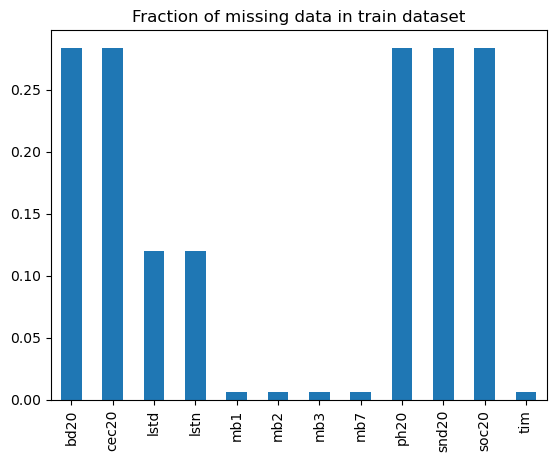

In [11]:
train_missing[train_missing > 0].plot.bar();
plt.title('Fraction of missing data in train dataset')

In [12]:
#data from the same source have the same proportion of missing data.

In [13]:
test_missing = 100 * test.isna().sum() / len(train) #%missing
test_missing[test_missing > 0]

bcount   0.221
dtype: float64

In [14]:
train.drop(columns='bcount', inplace = True)
test.drop(columns='bcount', inplace = True)

In [15]:
train.dtypes.value_counts()

float64    31
int64      13
object      3
Name: count, dtype: int64

In [16]:
test.dtypes.value_counts()

float64    31
int64      13
Name: count, dtype: int64

In [17]:
targets = train.select_dtypes(exclude=np.number).columns.tolist()

In [18]:
train.select_dtypes(int).head()

,bio1,bio12,bio7,bio15,lcc10,lcc11,lcc12,lcc13,lcc14,lcc21,lcc8,lcc9,mdem
subid,,,,,,,,,,,,,
1548937,262,1006,58,128,0,0,0,0,0,0,0,0,199
1548936,257,1118,70,162,0,0,0,0,0,0,0,0,362
1548935,265,930,66,154,0,0,0,24,0,0,0,0,288
1548934,263,875,67,156,0,0,0,0,0,0,0,0,320
1548933,260,1073,60,146,0,0,0,1,0,0,0,0,265


In [19]:
train.select_dtypes(float).head()

,lat,lon,x,y,bd20,cec20,dipa,dni,dnlt,dnpa,dor1,dor2,fpara,fpars,lstd,lstn,mb1,mb2,mb3,mb7,mlat,mlon,nppm,npps,ph20,sirm,sirs,slope,snd20,soc20,tim
subid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1548937,7.388,-4.780,-2714374.990,321874.970,1.490,9.750,165.717,946.728,0.500,0.000,1.803,1.768,44.716,330.218,15084.000,14665.000,993.000,3043.000,841.000,1261.000,7.389,-4.782,5052.300,853.451,6.100,0.717,0.008,0.729,66.750,12.250,8.079
1548936,8.690,-5.770,-2812624.967,474124.973,1.293,7.500,153.845,1184.871,3.913,9.618,17.862,0.250,48.036,220.700,15153.000,14695.000,827.000,2860.000,581.000,1294.000,8.691,-5.771,5316.700,933.074,5.575,0.717,0.007,1.087,51.500,14.250,9.549
1548935,8.519,-2.808,-2495125.034,440374.987,1.305,8.500,45.459,1081.140,7.616,36.835,30.751,0.707,43.784,261.888,15211.000,14699.000,773.000,2708.000,509.000,1231.000,8.520,-2.809,4519.700,1186.818,5.850,0.717,0.007,1.160,47.000,14.500,10.523
1548934,8.638,-3.049,-2520375.050,454875.008,1.327,8.750,16.342,1065.069,7.591,17.308,10.846,1.458,44.550,197.553,15188.000,14636.000,879.000,2831.000,616.000,1437.000,8.639,-3.050,3439.800,910.979,5.950,0.718,0.008,2.471,62.750,12.750,9.305
1548933,7.993,-6.044,-2846624.959,396624.944,1.420,9.000,219.401,1085.888,0.000,2.016,11.511,1.346,48.254,221.026,15130.000,14641.000,890.000,2780.000,732.000,1230.000,7.995,-6.045,5226.900,802.603,5.800,0.717,0.007,0.259,55.000,13.250,15.733


In [20]:
for col in targets:
    display(train[col].value_counts(normalize=True))

building
No    0.917
Yes   0.083
Name: proportion, dtype: float64

cropland
No    0.669
Yes   0.331
Name: proportion, dtype: float64

wcover
>60%   0.445
>30%   0.278
<30%   0.276
Name: proportion, dtype: float64

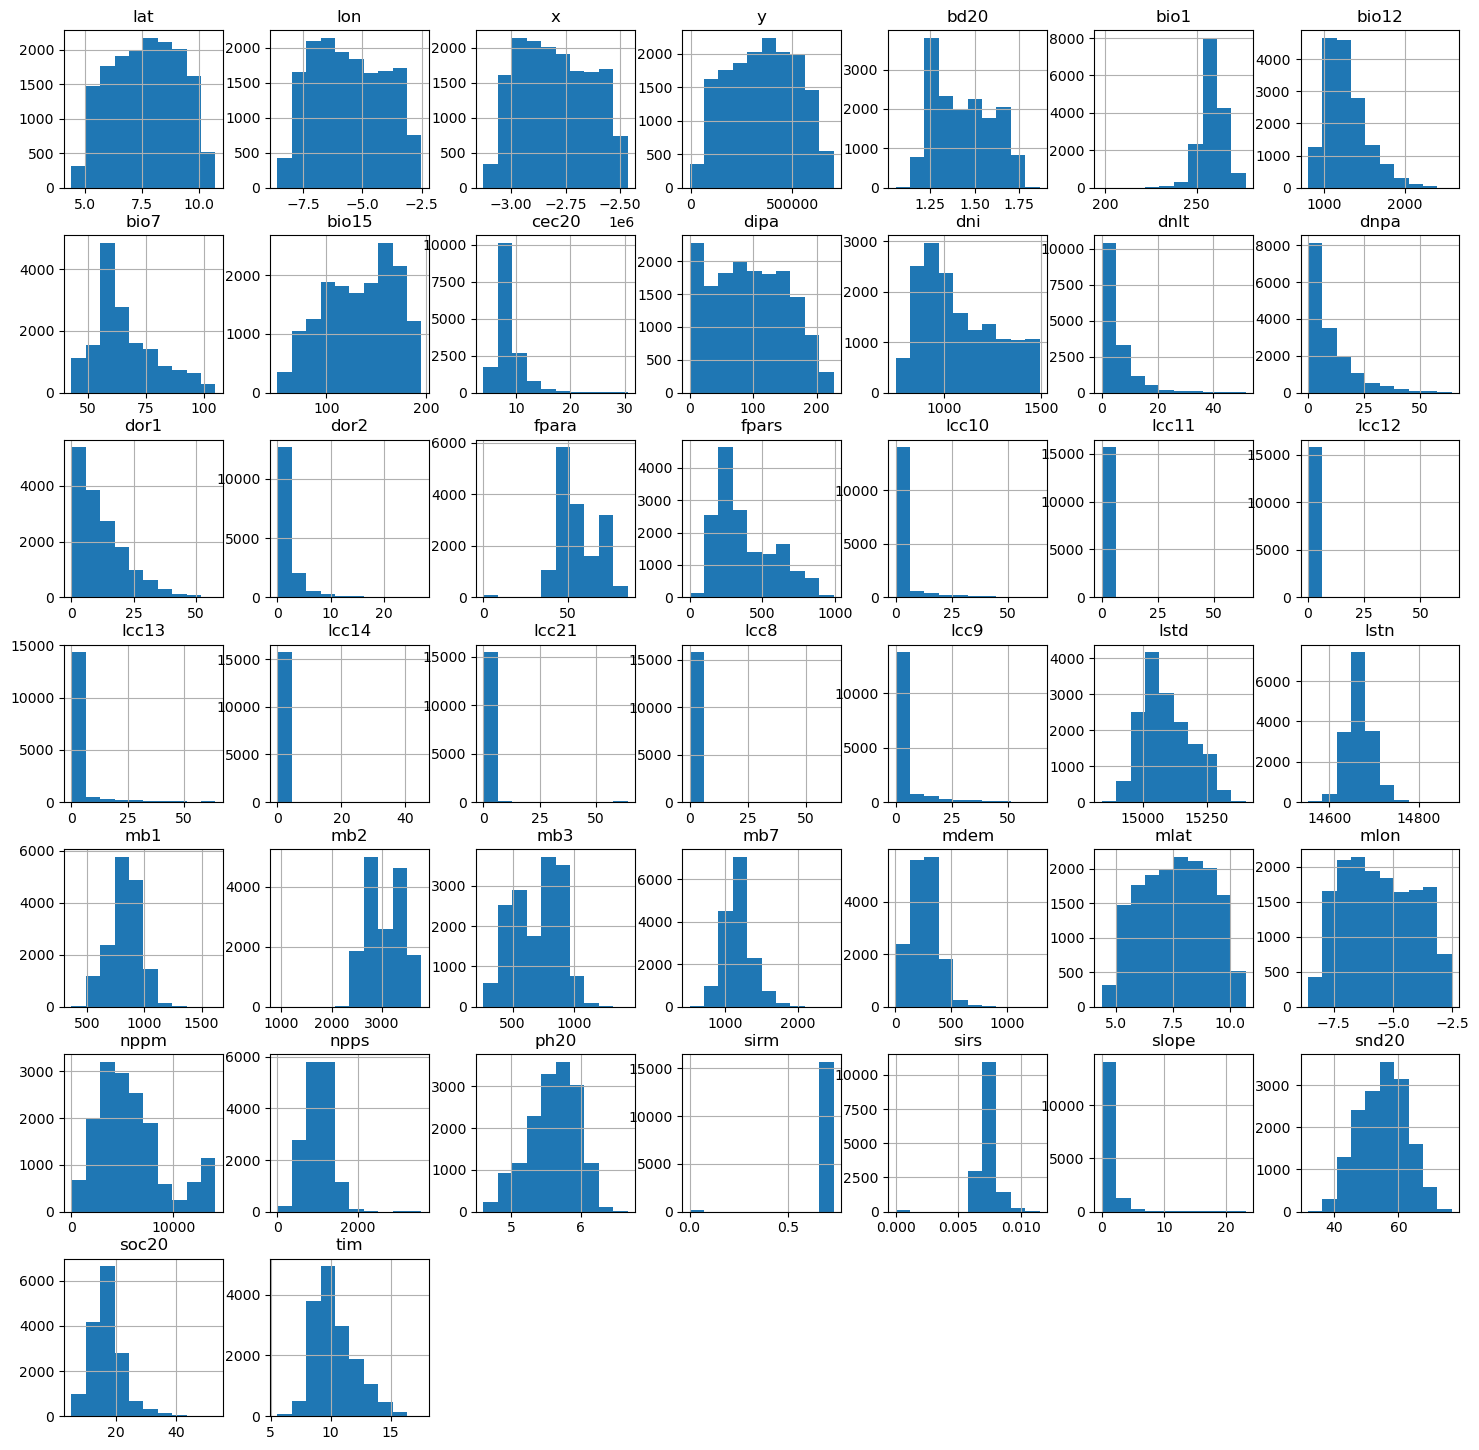

In [21]:
train.hist(figsize=(18, 18))
plt.title('train histogram');

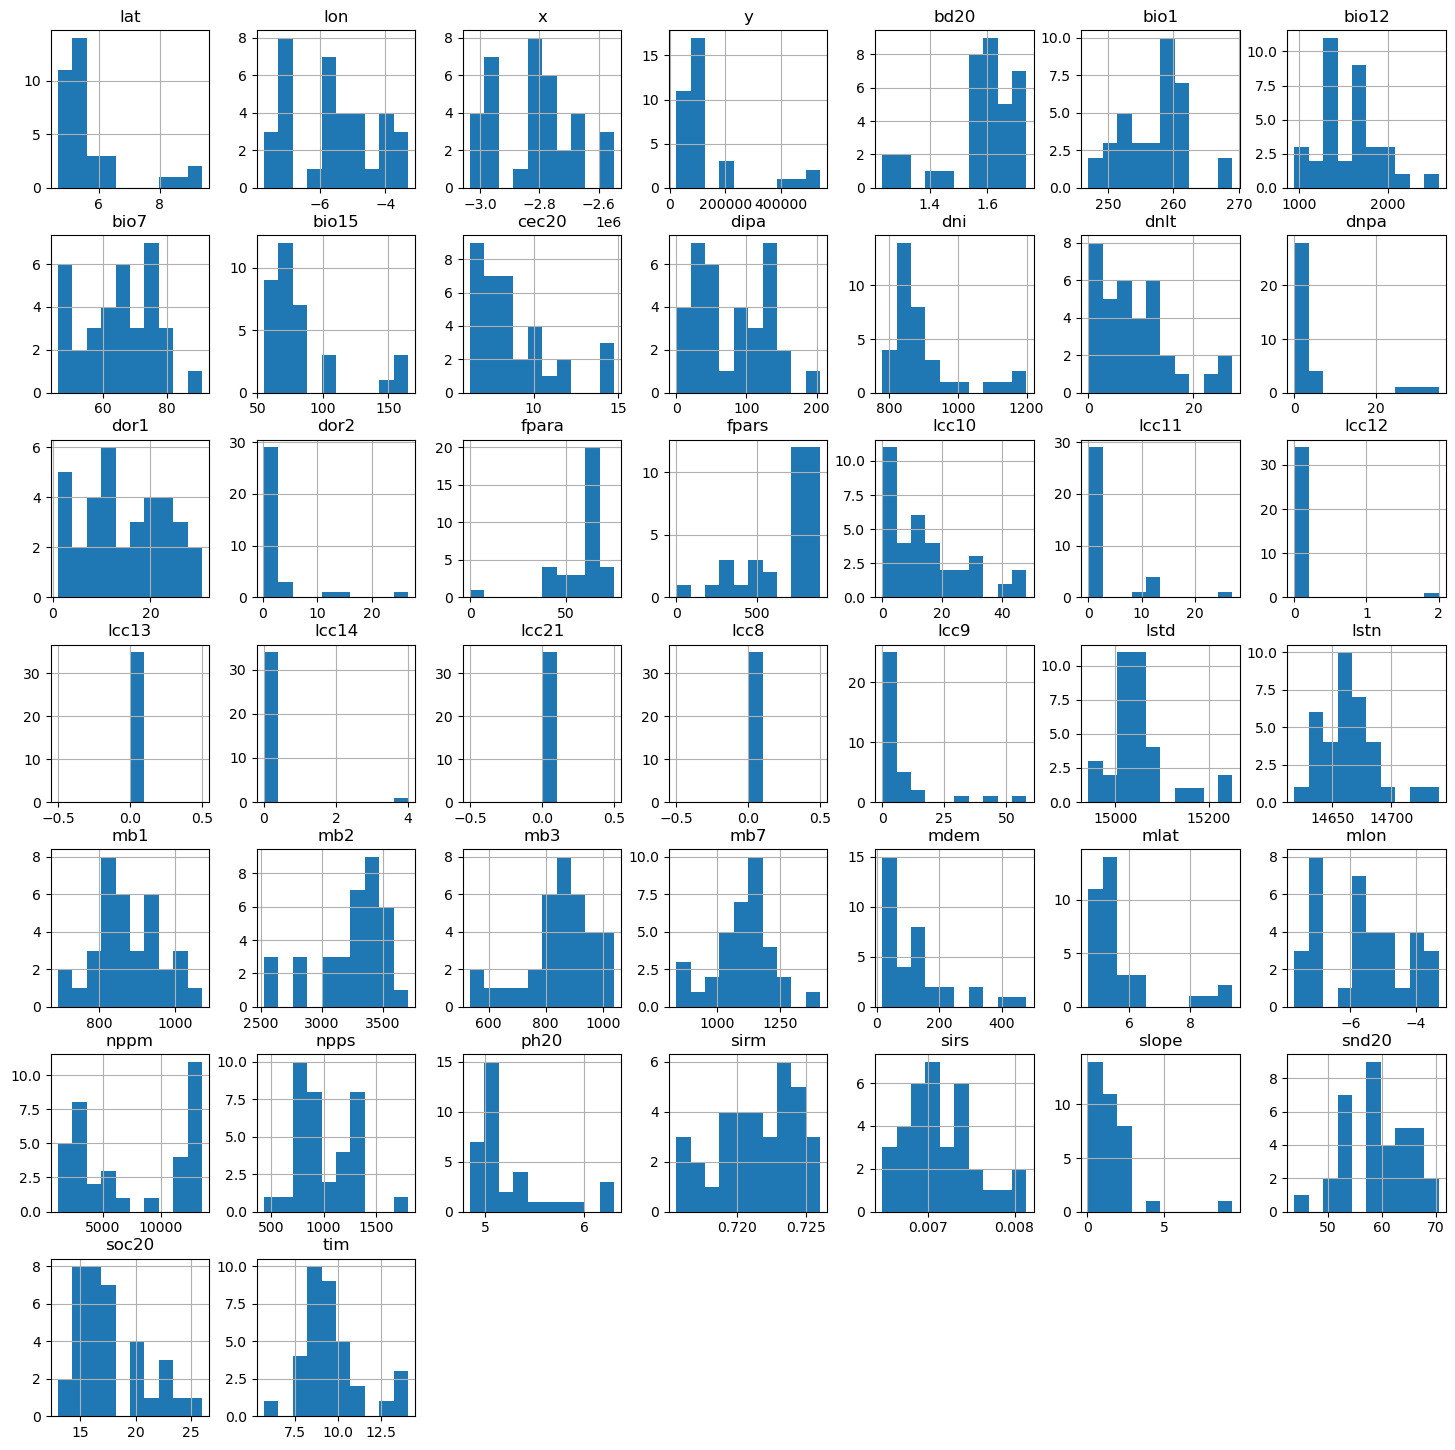

In [22]:
test.hist(figsize = (18, 18));
plt.title('test histogram');

Text(0.5, 1.0, 'train boxplot')

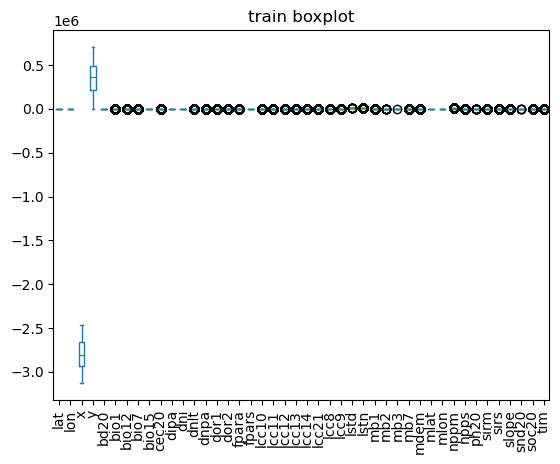

In [23]:
train.drop(columns=targets).plot(kind='box', rot=90);
plt.title('train boxplot')

Text(0.5, 1.0, 'test boxplot')

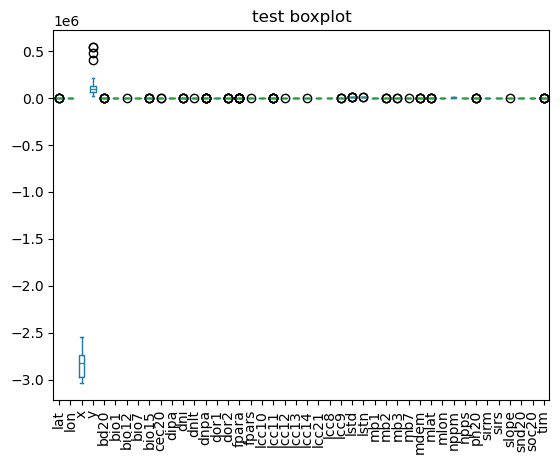

In [24]:
test.plot(kind='box', rot=90)
plt.title('test boxplot')

In [25]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
lat,15856.000,7.640,1.476,4.384,6.426,7.680,8.863,10.702
lon,15856.000,-5.558,1.500,-8.583,-6.827,-5.653,-4.271,-2.515
x,15856.000,-2795616.628,161307.162,-3128124.970,-2932875.023,-2806124.982,-2658562.497,-2465125.018
y,15856.000,354332.208,167481.073,-6374.980,217374.997,358874.966,492124.968,704375.050
bd20,15811.000,1.436,0.164,1.058,1.288,1.428,1.575,1.865
bio1,15856.000,258.907,6.578,198.000,255.000,259.000,263.000,277.000
bio12,15856.000,1276.894,253.891,802.000,1096.000,1225.000,1408.000,2586.000
bio7,15856.000,65.909,13.210,43.000,57.000,62.000,73.000,105.000
bio15,15856.000,132.873,35.501,51.000,104.000,136.000,164.000,195.000
cec20,15811.000,8.721,2.354,4.000,7.250,8.250,9.250,30.500


In [26]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
lat,35.000,5.737,1.241,4.666,5.023,5.399,5.676,9.390
lon,35.000,-5.671,1.278,-7.704,-7.056,-5.647,-4.932,-3.307
x,35.000,-2818725.005,141959.506,-3034874.969,-2972999.995,-2818125.039,-2738625.011,-2547125.026
y,35.000,139160.711,136837.740,23875.014,63749.957,100374.948,125624.962,541874.953
bd20,35.000,1.582,0.133,1.235,1.565,1.595,1.664,1.735
bio1,35.000,257.143,5.042,247.000,253.000,259.000,260.500,269.000
bio12,35.000,1568.800,333.588,951.000,1365.500,1576.000,1745.500,2564.000
bio7,35.000,64.686,11.362,46.000,55.000,67.000,73.000,91.000
bio15,35.000,83.400,30.028,55.000,65.000,76.000,81.500,165.000
cec20,35.000,8.793,2.285,6.250,7.125,8.250,9.875,14.750


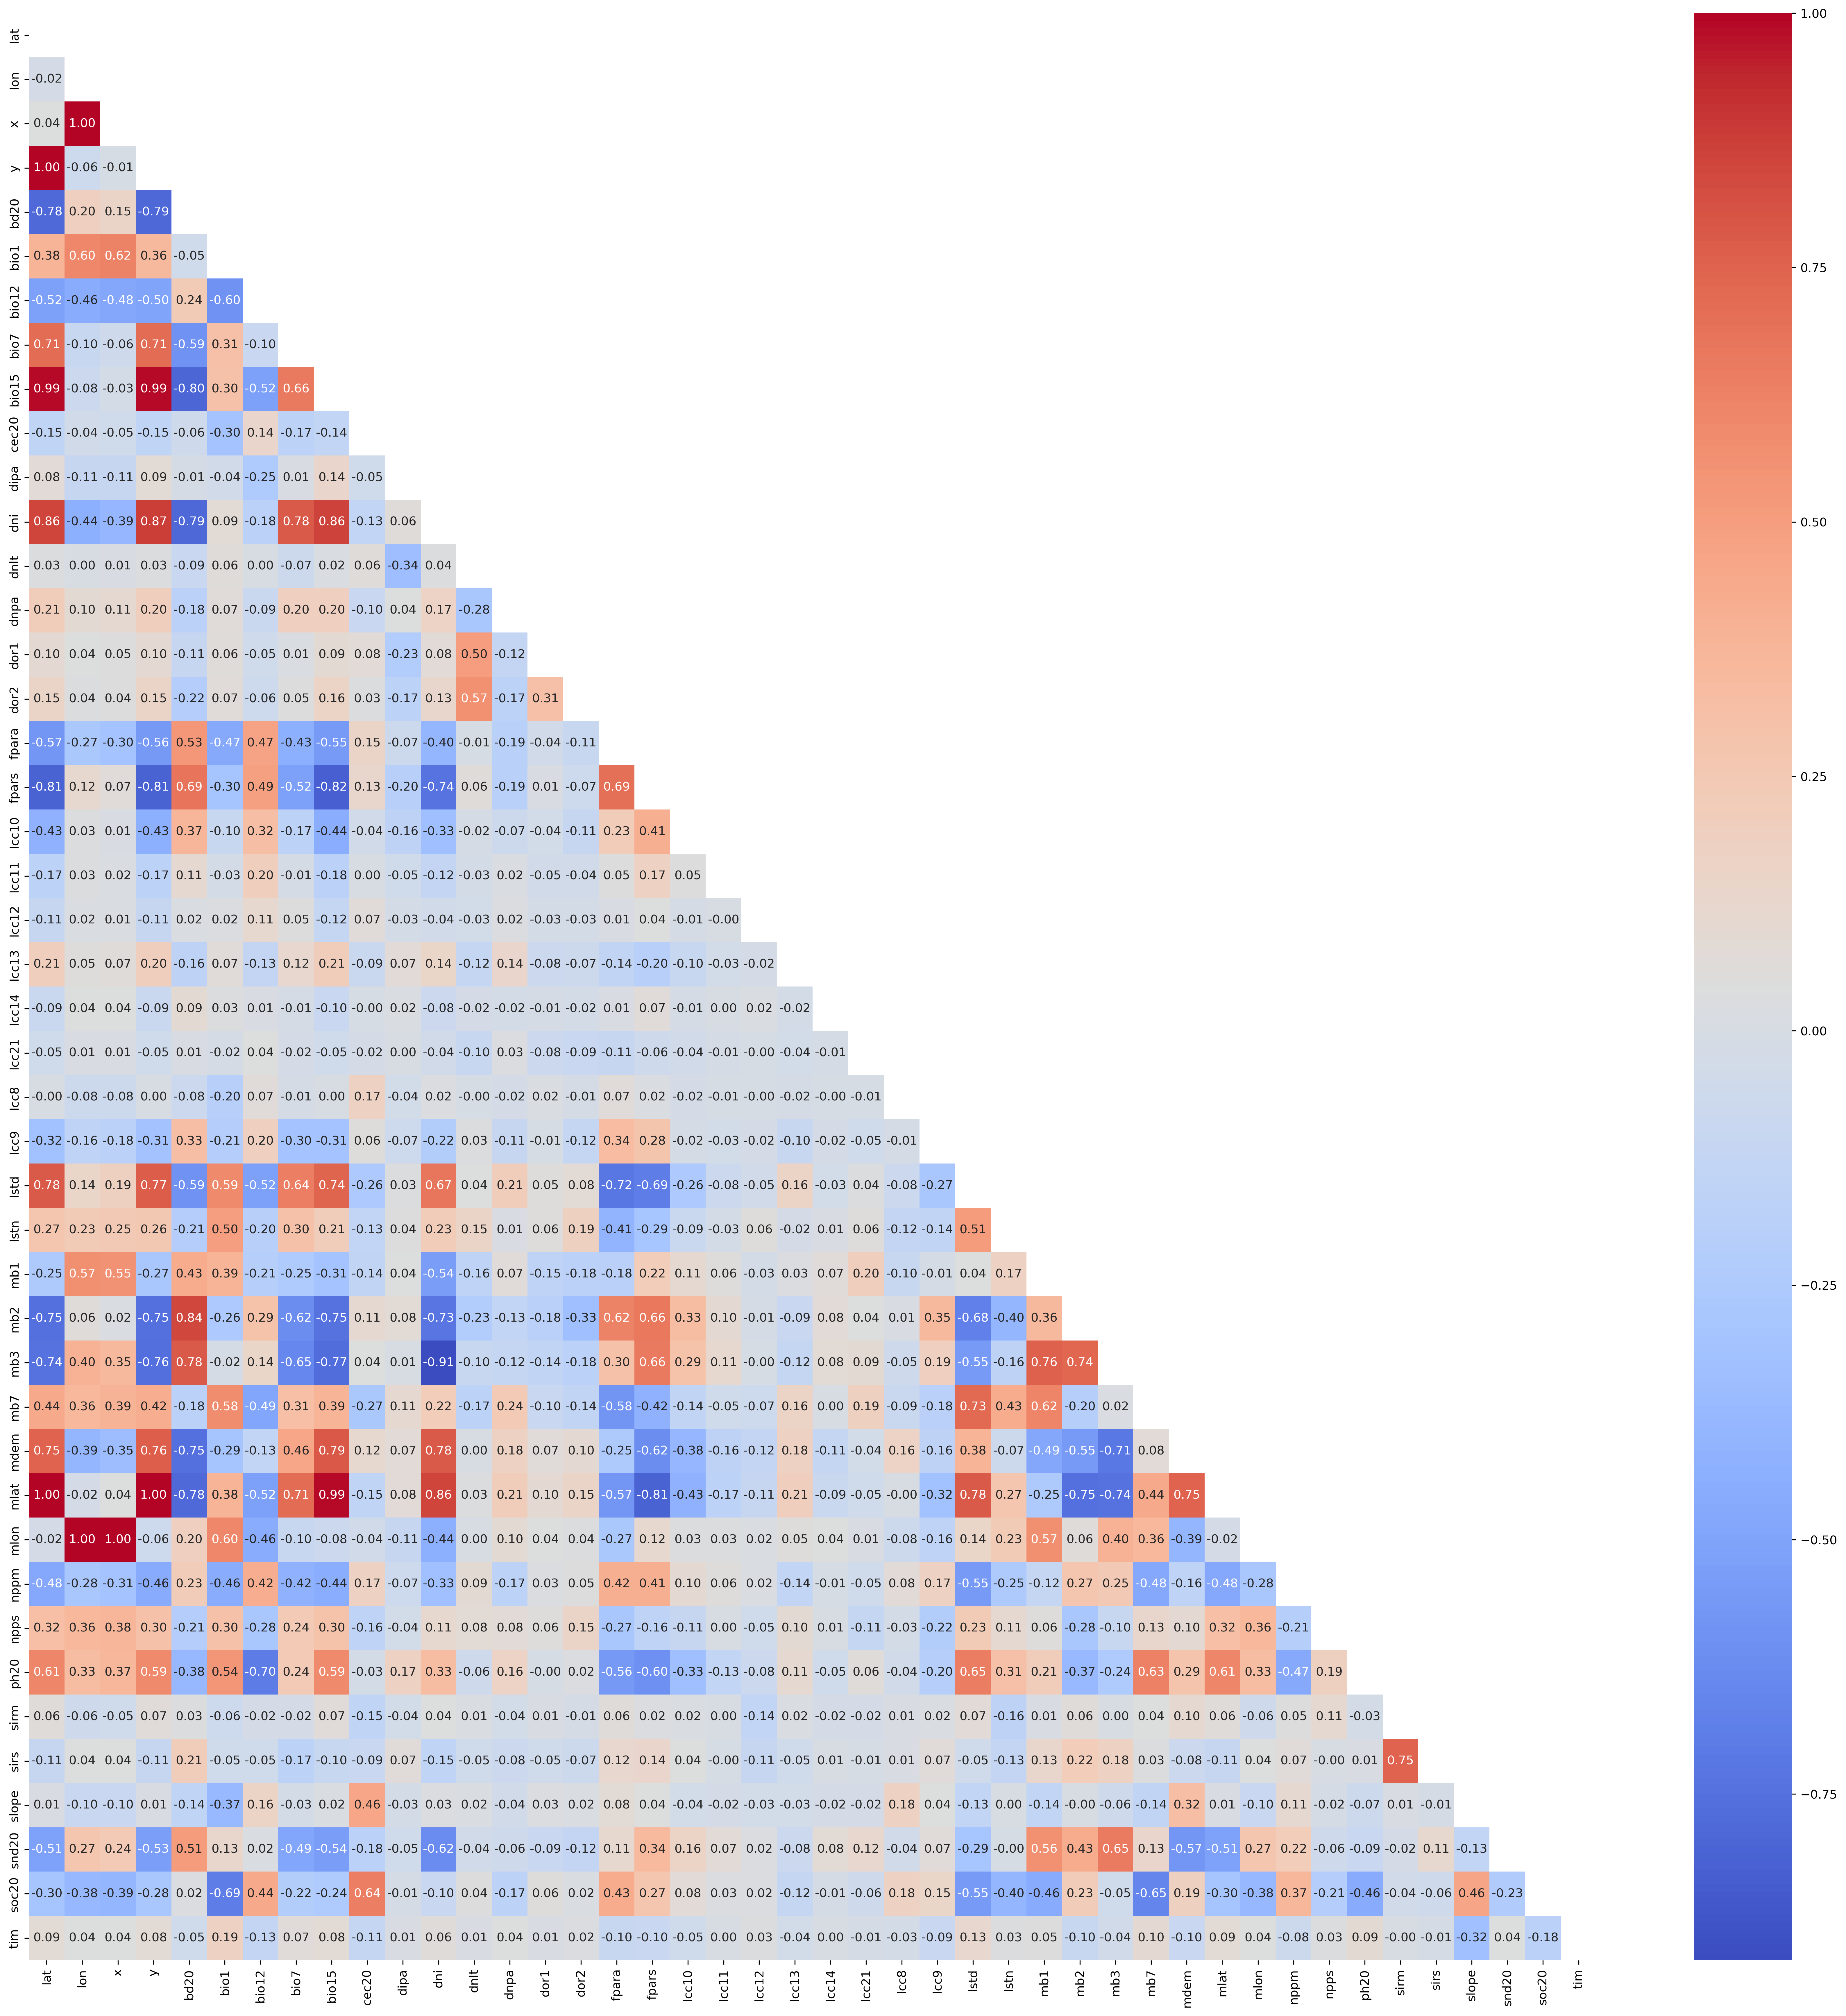

In [27]:
corr = train.select_dtypes(include=np.number).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(29, 29), dpi=300)
sns.heatmap(corr, mask = mask, annot=True, fmt='.2f', cmap='coolwarm',cbar = True)
plt.show()

#### Feature Engineering

In [28]:
#split data\n",
X = train.drop(columns=targets)
y = train[targets]

In [29]:
variables_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
Variable name,bd20,bio1,bio7,bio12,bio15,cec20,dipa,dni,dnpa,dor1,dor2,dows,fpara,fpars,lcc8,lcc9,lcc10,lcc11,lcc12,lcc13,lcc14,lcc21,lstd,lstn,mb1,mb2,mb3,mb7,mdem,mlat,mlon,nppa,npps,ph20,sirm,sire,slope,snd20,soc20,tim
Description,"Topsoil bulk density (Mg/m^3, soil fines)","Mean annual temperature (deg. C * 10, 1979-2013)","Mean annual temperature range (deg. C * 10, 1979-2013)","Mean annual precipitation (mm/yr, 1979-2013)","Mean rainfall seasonality (CV, 1979-2013)",Predicted topsoil cation exchange capacity (cmol/kg),Distance to internationally protected areas (km),Direct normal irradiation (kWhr/m^2),Distance to nationally protected areas (km),Distance to major road (km),Distance to any known road (km),Distance to surface water (km),Average fAPAR (2000-2021),SD fAPAR (2000-2021),Plantation de Cáfe (pixel count),Plantation de Cacao (pixel count),Plantation d'Hévéa (pixel count),Plantation de Palmier à huile (pixel count),Plantation de Coco (pixel count),Plantation d'Anacarde (pixel count),Aboricultures / Plantation fruititères (pixel count),Habitat humains et infrastrutures (pixel count),"Average day-time land surface temp. (deg. C , 2001-2020)","Average night-time land surface temp. (deg. C, 2001-2020)",Average MOD13Q1 band 1 reflectance (2001-2021),Average MOD13Q1 band 2 reflectance (2001-2021),Average MOD13Q1 band 3 reflectance (2001-2021),Average MOD13Q1 band 7 reflectance (2001-2021),Elevation above mean sea level (m),Pixel latitude (deg.),Pixel longitude (deg.),Average MOD17A3HGF NPP (gC/m^2/yr *0.1; 2000 - 2021),SD MOD17A3HGF NPP (gC/m^2/yr *0.1; 2000 - 2021),Predicted topsoil (0-20 cm) pH in water,Mean Strontium isotope ratio,SE Strtontium isotope ratio,Calculated slope (%),Predicted topsoil (0-20 cm) sand content (%),Predicted topsoil (0-20 cm) organic carbon content (g/kg),Topographic index map
Data source,SoilGrids,Chelsa,Chelsa,Chelsa,Chelsa,SoilGrids,ProtectedPlanet,GlobalSolarAtlas,ProtectedPlanet,Geofabrik,Geofabrik,SurfaceWater,MODIS,MODIS,BNETD,BNETD,BNETD,BNETD,BNETD,BNETD,BNETD,BNETD,MODIS,MODIS,MODIS,MODIS,MODIS,MODIS,MDEM,MDEM,MDEM,MODIS,MODIS,SoilGrids,"Wang et al, 2025","Wang et al, 2025",MDEM,SoilGrids,SoilGrids,MDEM
Original data link,https://soilgrids.org,http://chelsa-climate.org/downloads/,http://chelsa-climate.org/downloads/,http://chelsa-climate.org/downloads/,http://chelsa-climate.org/downloads/,https://soilgrids.org,http://www.protectedplanet.net/,https://globalsolaratlas.info/download/cote-d-ivoire,http://www.protectedplanet.net/,https://www.geofabrik.de/data/download.html,https://www.geofabrik.de/data/download.html,https://global-surface-water.appspot.com/,https://developers.google.com/earth-engine/datasets,https://developers.google.com/earth-engine/datasets,https://developers.google.com/earth-engine/datasets,https://developers.google.com/earth-engine/datasets,https://developers.google.com/earth-engine/datasets,https://developers.google.com/earth-engine/datasets,https://developers.google.com/earth-engine/datasets,https://developers.google.com/earth-engine/datasets,https://developers.google.com/earth-engine/datasets,https://developers.google.com/earth-engine/datasets,https://lpdaac.usgs.gov/product_search/,https://lpdaac.usgs.gov/product_search/,https://lpdaac.usgs.gov/product_search/,https://lpdaac.usgs.gov/product_search/,https://lpdaac.usgs.gov/product_search/,https://lpdaac.usgs.gov/product_search/,http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_DEM/,http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_DEM/,http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_DEM/,https://developers.google.com/earth-engine/datasets,https://developers.google.com/earth-engine/datasets,https://soilgrids.org,https://phys.org/news/2025-01-strontium-isotope-saharan-africa-powerful.html,https://phys.org/news/2025-01-strontium-isotope-saharan-africa-powerful.html,http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_DEM/,h

In [30]:
#feature engineering
X['surface_temp_diff'] = abs(X['lstd'] - X['lstn'])
test['surface_temp_diff'] = abs(test['lstd'] - test['lstn'])

In [31]:
target_encoder  = OrdinalEncoder(encoding_method='arbitrary', variables=targets)
y = target_encoder.fit_transform(y).astype(int)
y_buildings = y['building']
y_cropland = y['cropland']
y_wcover = y['wcover']

In [32]:
target_encoder.encoder_dict_

{'building': {'No': 0, 'Yes': 1},
 'cropland': {'No': 0, 'Yes': 1},
 'wcover': {'>60%': 0, '<30%': 1, '>30%': 2}}

In [33]:
X[['lon', 'lat', 'mlat', 'mlon', 'x', 'y']].corr()

,lon,lat,mlat,mlon,x,y
lon,1.000,-0.018,-0.018,1.000,0.998,-0.061
lat,-0.018,1.000,1.000,-0.018,0.038,0.999
mlat,-0.018,1.000,1.000,-0.018,0.038,0.999
mlon,1.000,-0.018,-0.018,1.000,0.998,-0.061
x,0.998,0.038,0.038,0.998,1.000,-0.006
y,-0.061,0.999,0.999,-0.061,-0.006,1.000


In [34]:
X.drop(columns=['mlat', 'mlon', 'x', 'y'], inplace=True)
test.drop(columns=['mlat', 'mlon', 'x', 'y'], inplace=True)

In [35]:
X.shape, test.shape

((15856, 41), (35, 41))

In [36]:
X = X.fillna(0)

In [37]:
X.head()

,lat,lon,bd20,bio1,bio12,bio7,bio15,cec20,dipa,dni,dnlt,dnpa,dor1,dor2,fpara,fpars,lcc10,lcc11,lcc12,lcc13,lcc14,lcc21,lcc8,lcc9,lstd,lstn,mb1,mb2,mb3,mb7,mdem,nppm,npps,ph20,sirm,sirs,slope,snd20,soc20,tim,surface_temp_diff
subid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1548937,7.388,-4.780,1.490,262,1006,58,128,9.750,165.717,946.728,0.500,0.000,1.803,1.768,44.716,330.218,0,0,0,0,0,0,0,0,15084.000,14665.000,993.000,3043.000,841.000,1261.000,199,5052.300,853.451,6.100,0.717,0.008,0.729,66.750,12.250,8.079,419.000
1548936,8.690,-5.770,1.293,257,1118,70,162,7.500,153.845,1184.871,3.913,9.618,17.862,0.250,48.036,220.700,0,0,0,0,0,0,0,0,15153.000,14695.000,827.000,2860.000,581.000,1294.000,362,5316.700,933.074,5.575,0.717,0.007,1.087,51.500,14.250,9.549,458.000
1548935,8.519,-2.808,1.305,265,930,66,154,8.500,45.459,1081.140,7.616,36.835,30.751,0.707,43.784,261.888,0,0,0,24,0,0,0,0,15211.000,14699.000,773.000,2708.000,509.000,1231.000,288,4519.700,1186.818,5.850,0.717,0.007,1.160,47.000,14.500,10.523,512.000
1548934,8.638,-3.049,1.327,263,875,67,156,8.750,16.342,1065.069,7.591,17.308,10.846,1.458,44.550,197.553,0,0,0,0,0,0,0,0,15188.000,14636.000,879.000,2831.000,616.000,1437.000,320,3439.800,910.979,5.950,0.718,0.008,2.471,62.750,12.750,9.305,552.000
1548933,7.993,-6.044,1.420,260,1073,60,146,9.000,219.401,1085.888,0.000,2.016,11.511,1.346,48.254,221.026,0,0,0,1,0,0,0,0,15130.000,14641.000,890.000,2780.000,732.000,1230.000,265,5226.900,802.603,5.800,0.717,0.007,0.259,55.000,13.250,15.733,489.000


In [38]:
test.head()

,lat,lon,bd20,bio1,bio12,bio7,bio15,cec20,dipa,dni,dnlt,dnpa,dor1,dor2,fpara,fpars,lcc10,lcc11,lcc12,lcc13,lcc14,lcc21,lcc8,lcc9,lstd,lstn,mb1,mb2,mb3,mb7,mdem,nppm,npps,ph20,sirm,sirs,slope,snd20,soc20,tim,surface_temp_diff
subid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1548905,4.825,-7.523,1.408,250,2564,46,61,8.500,61.519,901.802,10.440,31.286,4.828,1.904,63.477,829.379,23,11,0,0,0,0,0,0,14967.000,14681.000,692.000,2875.000,723.000,883.000,118,12909.700,870.217,5.025,0.719,0.007,4.093,64.500,23.500,9.168,286.000
1548829,5.458,-5.010,1.635,261,1378,71,76,6.500,124.008,830.578,12.395,0.000,16.919,0.250,61.338,811.828,16,2,0,0,0,0,0,6,15054.000,14653.000,929.000,3249.000,944.000,1076.000,37,12288.300,839.144,4.850,0.724,0.007,0.488,65.750,13.000,7.896,401.000
1548811,5.082,-7.149,1.582,247,1704,46,67,14.000,15.542,894.497,26.077,0.000,24.839,0.901,61.828,730.281,0,0,0,0,0,0,0,58,15011.000,14653.000,786.000,3026.000,801.000,1000.000,220,13374.500,763.726,5.100,0.720,0.006,2.114,52.000,23.250,7.606,358.000
1548806,5.673,-4.171,1.735,261,1700,68,76,6.750,43.018,803.185,0.000,0.000,7.988,0.559,62.820,838.265,33,1,0,0,0,0,0,0,15026.000,14664.000,910.000,3499.000,886.000,1117.000,49,11717.200,814.182,5.125,0.724,0.007,0.963,59.750,15.000,8.471,362.000
1548798,4.666,-7.041,1.592,259,1724,61,55,6.500,60.299,922.987,0.000,0.000,1.275,0.791,67.465,775.759,31,0,0,0,4,0,0,0,15027.000,14683.000,826.000,3142.000,873.000,1023.000,23,3474.800,1809.494,4.950,0.717,0.007,0.779,70.500,15.750,13.725,344.000


#### Modeling
* Treat task as multiple classification tasks as targets are independent of each other
* Establish a baseline for all tasks
* Perform hparam tuning for selected models and their hparams
* Evaluate model & Visualize model
* 

In [39]:
#establish baselines per target
for y_ , subtarget in zip([y_buildings, y_cropland, y_wcover], ['buildings', 'croplands', 'wcovers']):
    Xtrain, Xval, ytrain, yval = train_test_split(X, y_, test_size = .2, random_state = 101, stratify = y_, shuffle=True)
    xgbm = XGBClassifier()
    xgbm.fit(Xtrain, ytrain)
    if len(y_.unique()) > 2:
        train_score = roc_auc_score(ytrain, xgbm.predict_proba(Xtrain), multi_class='ovo')
        val_score = roc_auc_score(yval, xgbm.predict_proba(Xval), multi_class='ovo')
        print(f'XGBoost Baseline for {subtarget} has train roc auc of {train_score : .2f} and val auc score of {val_score : .2f}')
    else:
        train_score = roc_auc_score(ytrain, xgbm.predict_proba(Xtrain)[:, -1], multi_class='ovo')
        val_score = roc_auc_score(yval, xgbm.predict_proba(Xval)[:, -1], multi_class='ovo')
        print(f'XGBoost Baseline for {subtarget} has train roc auc of {train_score : .2f} and val auc score of {val_score : .2f}')
    


XGBoost Baseline for buildings has train roc auc of  1.00 and val auc score of  0.80
XGBoost Baseline for croplands has train roc auc of  0.99 and val auc score of  0.81
XGBoost Baseline for wcovers has train roc auc of  0.99 and val auc score of  0.73


In [40]:
def plot_feature_importance(model, feature_names, model_type='xgboost', top_n=20):

    if model_type == 'xgboost':
        importance = model.get_booster().get_score(importance_type='weight')
    elif model_type == 'lightgbm':
        importance = model.feature_importances_
    elif model_type == 'catboost':
        importance = model.get_feature_importance()
    else:
        raise ValueError("Unsupported model type. Choose from 'xgboost', 'lightgbm', or 'catboost'.")
    
    if model_type == 'xgboost':
        feature_importance = pd.DataFrame({'Feature': importance.keys(), 'Importance': importance.values()})
    else:
        feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"Top {top_n} Feature Importances ({model_type.capitalize()})")
    plt.show()


In [41]:
def tune_hyperparameters(model_class, X, y, n_trials=10):
    def objective(trial):
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
        model = None
        if model_class == 'xgb':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'random_state': 101
            }
            model = XGBClassifier(**params)
        elif model_class == 'cb':
            params = {
                'iterations': trial.suggest_int('iterations', 100, 300),
                'depth': trial.suggest_int('depth', 4, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'random_state': 101,
                'verbose': False  
            }
            model = CatBoostClassifier(**params, auto_class_weights='Balanced')
        elif model_class == 'lgbm':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'random_state': 101,
                'verbosity' : -1
            }
            model = LGBMClassifier(**params, class_weight='balanced')
        

        # Perform K-Fold CV
        scores = cross_val_score(model, X, y, cv=kf, scoring='roc_auc_ovr_weighted')
        return scores.mean()

    # Run Optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    # Return best hyperparameters and study results
    return study.best_params, study.best_value, study.trials_dataframe()


In [42]:
def train_best_model_and_predict(X, y, test_df, results_df, use_predict = False):
    # Get the best model for the target
    display(results_df)
    best_model_info = results_df.sort_values(by='mean_metric', ascending=False).iloc[0]
    model_name = best_model_info['model_name']
    best_params = best_model_info['best_params']

    print(f'Best model: {model_name}')
    # Initialize the best model
    if model_name == 'XGBoost':
        model = XGBClassifier(**best_params)
    elif model_name == 'CatBoost':
        model = CatBoostClassifier(**best_params, verbose = 0)
    elif model_name == 'LightGBM':
        model = LGBMClassifier(**best_params, verbosity = -1)
    else:
        raise ValueError("Unsupported model name")

    # Train the model
    model.fit(X, y)
    plot_feature_importance(model, X.columns.tolist(), model_type=model_name.lower( ))
    if  use_predict:
        predictions = model.predict(test_df)
    else:
        predictions = model.predict_proba(test_df)[:, -1]
    return predictions

In [43]:
def evaluate_models(models, X, y, labels, n_trials = 2):
    results = []
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, shuffle=True, random_state=101, test_size = .1)
    for model_name, model_class in models.items():
        print(f"Tuning {model_name}...")
        best_params, best_score, trials_df = tune_hyperparameters(model_class, Xtrain, ytrain, n_trials = n_trials)
        
        results.append({
            'model_name': model_name,
            'best_params': best_params,
            'mean_metric': best_score,
            'stdev_metric': trials_df['value'].std()
        })

    # Convert results to DataFrame
    results_df =  pd.DataFrame(results).sort_values(by='mean_metric', ascending=False).reset_index(drop = True)

    #evaluate best model on holdout set


    #using classification report
    ypred = train_best_model_and_predict(Xtrain, ytrain, Xtest, results_df, use_predict=True)
    report_dict = classification_report(ytest, ypred, output_dict=True, target_names = labels)
    report_df = pd.DataFrame(report_dict).transpose()
    display(report_df)

    #confusion matrix
    ConfusionMatrixDisplay.from_predictions(ytest, ypred, display_labels=labels, cmap='bone', normalize = 'all')
    plt.show()



    return results_df

In [44]:
target_encoder.encoder_dict_

{'building': {'No': 0, 'Yes': 1},
 'cropland': {'No': 0, 'Yes': 1},
 'wcover': {'>60%': 0, '<30%': 1, '>30%': 2}}

In [45]:
building_labels = list(target_encoder.encoder_dict_['building'].keys())
cropland_labels = list(target_encoder.encoder_dict_['cropland'].keys())
wcover_labels = list(target_encoder.encoder_dict_['wcover'].keys())
building_labels

['No', 'Yes']

[I 2025-03-19 07:32:22,995] A new study created in memory with name: no-name-8e18a9fa-39dd-4080-a55c-16117568a183


Tuning XGBoost...


[I 2025-03-19 07:32:27,068] Trial 0 finished with value: 0.8170588605176474 and parameters: {'n_estimators': 212, 'max_depth': 4, 'learning_rate': 0.2544500266512808, 'subsample': 0.8155057899512089, 'colsample_bytree': 0.6446317495423174}. Best is trial 0 with value: 0.8170588605176474.
[I 2025-03-19 07:32:36,178] Trial 1 finished with value: 0.8379827450828646 and parameters: {'n_estimators': 245, 'max_depth': 6, 'learning_rate': 0.04636251091076496, 'subsample': 0.9788102908919801, 'colsample_bytree': 0.9095357048113282}. Best is trial 1 with value: 0.8379827450828646.
[I 2025-03-19 07:32:36,194] A new study created in memory with name: no-name-abb5872a-8d20-4638-8cf0-0d3bd9c26bec


Tuning CatBoost...


[I 2025-03-19 07:32:42,393] Trial 0 finished with value: 0.8298257579055477 and parameters: {'iterations': 103, 'depth': 4, 'learning_rate': 0.03552306361533699}. Best is trial 0 with value: 0.8298257579055477.
[I 2025-03-19 07:32:49,681] Trial 1 finished with value: 0.8273331301825616 and parameters: {'iterations': 136, 'depth': 4, 'learning_rate': 0.17805269047222377}. Best is trial 0 with value: 0.8298257579055477.
[I 2025-03-19 07:32:49,685] A new study created in memory with name: no-name-c5ba6031-161d-4d2b-92d9-b4da2382b2e6


Tuning LightGBM...


[I 2025-03-19 07:32:51,943] Trial 0 finished with value: 0.8117669441448239 and parameters: {'n_estimators': 146, 'max_depth': 7, 'learning_rate': 0.29228318240866186, 'subsample': 0.6267844144201293, 'colsample_bytree': 0.6930984171806484}. Best is trial 0 with value: 0.8117669441448239.
[I 2025-03-19 07:32:53,448] Trial 1 finished with value: 0.8255553996991434 and parameters: {'n_estimators': 203, 'max_depth': 3, 'learning_rate': 0.2068811013392408, 'subsample': 0.8943196959700126, 'colsample_bytree': 0.6984021907318888}. Best is trial 1 with value: 0.8255553996991434.


,model_name,best_params,mean_metric,stdev_metric
0,XGBoost,"{'n_estimators': 245, 'max_depth': 6, 'learning_rate': 0.04636251091076496, 'subsample': 0.9788102908919801, 'colsample_bytree': 0.9095357048113282}",0.838,0.015
1,CatBoost,"{'iterations': 103, 'depth': 4, 'learning_rate': 0.03552306361533699}",0.830,0.002
2,LightGBM,"{'n_estimators': 203, 'max_depth': 3, 'learning_rate': 0.2068811013392408, 'subsample': 0.8943196959700126, 'colsample_bytree': 0.6984021907318888}",0.826,0.010


Best model: XGBoost


C:\Users\USER\AppData\Local\Temp\ipykernel_15904\194810284.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


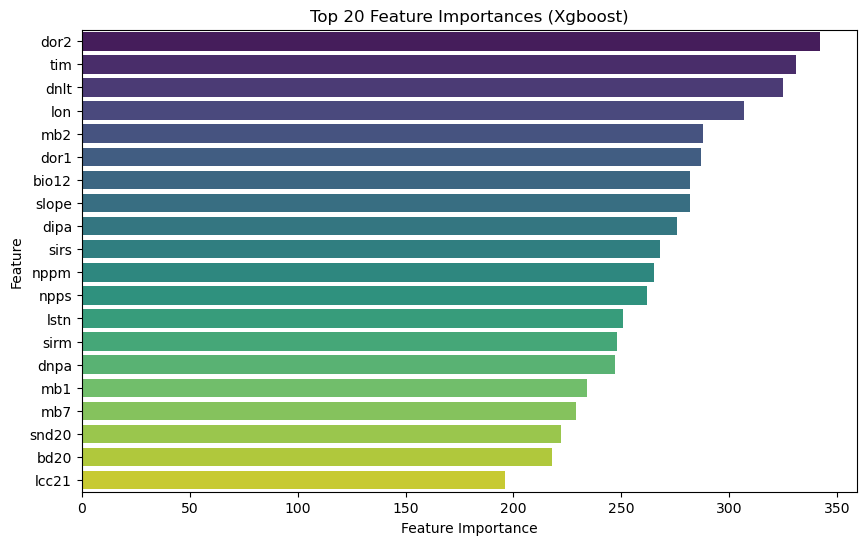

,precision,recall,f1-score,support
No,0.942,0.997,0.968,1454.000
Yes,0.894,0.318,0.469,132.000
accuracy,0.940,0.940,0.940,0.940
macro avg,0.918,0.657,0.719,1586.000
weighted avg,0.938,0.940,0.927,1586.000


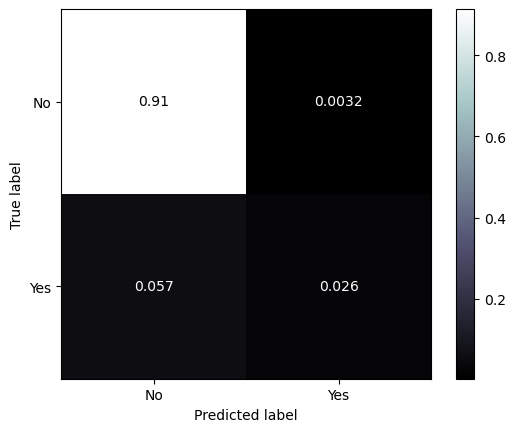

,model_name,best_params,mean_metric,stdev_metric
0,XGBoost,"{'n_estimators': 245, 'max_depth': 6, 'learning_rate': 0.04636251091076496, 'subsample': 0.9788102908919801, 'colsample_bytree': 0.9095357048113282}",0.838,0.015
1,CatBoost,"{'iterations': 103, 'depth': 4, 'learning_rate': 0.03552306361533699}",0.830,0.002
2,LightGBM,"{'n_estimators': 203, 'max_depth': 3, 'learning_rate': 0.2068811013392408, 'subsample': 0.8943196959700126, 'colsample_bytree': 0.6984021907318888}",0.826,0.010


In [46]:
models = {
    'XGBoost': 'xgb',
    'CatBoost': 'cb',
    'LightGBM': 'lgbm'
}

results_df_buildings = evaluate_models(models, X, y_buildings,  building_labels)
display(results_df_buildings)

results_df_buildings.to_csv('model_tuning_results_buildings.csv', index=False)


[I 2025-03-19 04:05:25,118] A new study created in memory with name: no-name-dfc290e5-42d3-4007-bcfd-4e1d87ec32a4


Tuning XGBoost...


[I 2025-03-19 04:05:35,575] Trial 0 finished with value: 0.837249151272791 and parameters: {'n_estimators': 137, 'max_depth': 9, 'learning_rate': 0.07045037508825908, 'subsample': 0.9045577086667573, 'colsample_bytree': 0.6489937217914928}. Best is trial 0 with value: 0.837249151272791.
[I 2025-03-19 04:05:40,829] Trial 1 finished with value: 0.8346603044878551 and parameters: {'n_estimators': 290, 'max_depth': 4, 'learning_rate': 0.06845388216944444, 'subsample': 0.8745478550381018, 'colsample_bytree': 0.8205978587545477}. Best is trial 0 with value: 0.837249151272791.
[I 2025-03-19 04:05:40,837] A new study created in memory with name: no-name-96f33bce-d182-45d5-97b2-7ae646849797


Tuning CatBoost...


[I 2025-03-19 04:05:50,444] Trial 0 finished with value: 0.8258003773561704 and parameters: {'iterations': 114, 'depth': 6, 'learning_rate': 0.2420545483397689}. Best is trial 0 with value: 0.8258003773561704.
[I 2025-03-19 04:08:13,448] Trial 1 finished with value: 0.8319123235149954 and parameters: {'iterations': 243, 'depth': 10, 'learning_rate': 0.08723989862545489}. Best is trial 1 with value: 0.8319123235149954.
[I 2025-03-19 04:08:13,454] A new study created in memory with name: no-name-85446900-2c6f-484d-956f-36f49e338e89


Tuning LightGBM...


[I 2025-03-19 04:08:17,569] Trial 0 finished with value: 0.8359465321892252 and parameters: {'n_estimators': 253, 'max_depth': 9, 'learning_rate': 0.0417646819757786, 'subsample': 0.910682986453129, 'colsample_bytree': 0.949083948048992}. Best is trial 0 with value: 0.8359465321892252.
[I 2025-03-19 04:08:19,439] Trial 1 finished with value: 0.8228856769100034 and parameters: {'n_estimators': 193, 'max_depth': 5, 'learning_rate': 0.24572367171088252, 'subsample': 0.9032141435817357, 'colsample_bytree': 0.695248113564012}. Best is trial 0 with value: 0.8359465321892252.


,model_name,best_params,mean_metric,stdev_metric
0,XGBoost,"{'n_estimators': 137, 'max_depth': 9, 'learning_rate': 0.07045037508825908, 'subsample': 0.9045577086667573, 'colsample_bytree': 0.6489937217914928}",0.837,0.002
1,LightGBM,"{'n_estimators': 253, 'max_depth': 9, 'learning_rate': 0.0417646819757786, 'subsample': 0.910682986453129, 'colsample_bytree': 0.949083948048992}",0.836,0.009
2,CatBoost,"{'iterations': 243, 'depth': 10, 'learning_rate': 0.08723989862545489}",0.832,0.004


Best model: XGBoost


C:\Users\USER\AppData\Local\Temp\ipykernel_6116\194810284.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


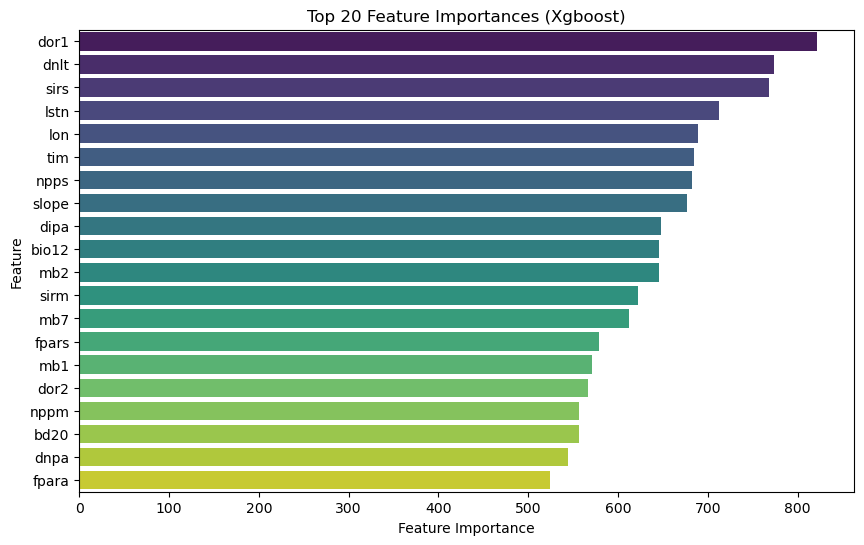

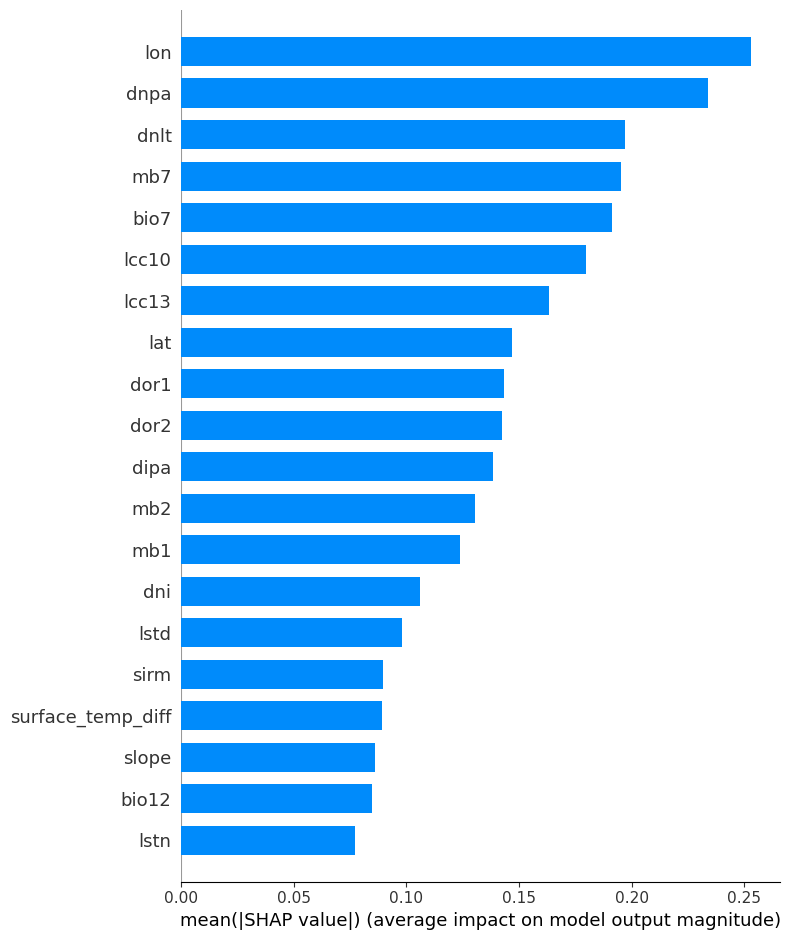

,precision,recall,f1-score,support
No,0.799,0.880,0.838,1061.000
Yes,0.695,0.552,0.616,525.000
accuracy,0.772,0.772,0.772,0.772
macro avg,0.747,0.716,0.727,1586.000
weighted avg,0.765,0.772,0.764,1586.000


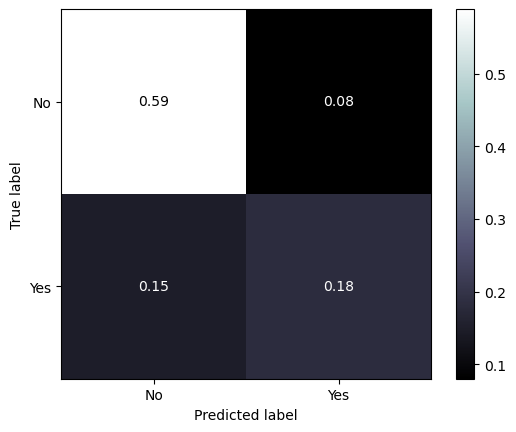

,model_name,best_params,mean_metric,stdev_metric
0,XGBoost,"{'n_estimators': 137, 'max_depth': 9, 'learning_rate': 0.07045037508825908, 'subsample': 0.9045577086667573, 'colsample_bytree': 0.6489937217914928}",0.837,0.002
1,LightGBM,"{'n_estimators': 253, 'max_depth': 9, 'learning_rate': 0.0417646819757786, 'subsample': 0.910682986453129, 'colsample_bytree': 0.949083948048992}",0.836,0.009
2,CatBoost,"{'iterations': 243, 'depth': 10, 'learning_rate': 0.08723989862545489}",0.832,0.004


In [49]:
models = {
    'XGBoost': 'xgb',
    'CatBoost': 'cb',
    'LightGBM': 'lgbm'
}

results_df_cropland = evaluate_models(models, X, y_cropland, cropland_labels)
display(results_df_cropland)

results_df_cropland.to_csv('model_tuning_results_cropland.csv', index=False)

[I 2025-03-19 07:32:56,382] A new study created in memory with name: no-name-a5f9bc79-c0fd-498c-97c2-dae145edc197


Tuning XGBoost...


[I 2025-03-19 07:33:04,630] Trial 0 finished with value: 0.747165234546719 and parameters: {'n_estimators': 151, 'max_depth': 4, 'learning_rate': 0.2511321633892873, 'subsample': 0.7624259032179503, 'colsample_bytree': 0.9555007066636739}. Best is trial 0 with value: 0.747165234546719.
[I 2025-03-19 07:34:25,011] Trial 1 finished with value: 0.7540995565266293 and parameters: {'n_estimators': 242, 'max_depth': 10, 'learning_rate': 0.04740696115040889, 'subsample': 0.8184809494967662, 'colsample_bytree': 0.9884981792358092}. Best is trial 1 with value: 0.7540995565266293.
[I 2025-03-19 07:34:25,021] A new study created in memory with name: no-name-62026e89-0a60-44bc-9e7c-5bac1fdf0446


Tuning CatBoost...


[I 2025-03-19 07:34:39,892] Trial 0 finished with value: 0.7511441514608965 and parameters: {'iterations': 204, 'depth': 5, 'learning_rate': 0.15113011665494827}. Best is trial 0 with value: 0.7511441514608965.
[I 2025-03-19 07:35:05,591] Trial 1 finished with value: 0.744107906923 and parameters: {'iterations': 244, 'depth': 6, 'learning_rate': 0.26865533016160464}. Best is trial 0 with value: 0.7511441514608965.
[I 2025-03-19 07:35:05,597] A new study created in memory with name: no-name-7524e3c9-70f0-495d-8061-1c27c18c637e


Tuning LightGBM...


[I 2025-03-19 07:35:12,198] Trial 0 finished with value: 0.7376428940496134 and parameters: {'n_estimators': 252, 'max_depth': 5, 'learning_rate': 0.23031795530136198, 'subsample': 0.7199361242273994, 'colsample_bytree': 0.8172560124719865}. Best is trial 0 with value: 0.7376428940496134.
[I 2025-03-19 07:35:21,647] Trial 1 finished with value: 0.7417200863253053 and parameters: {'n_estimators': 268, 'max_depth': 10, 'learning_rate': 0.1997315407765046, 'subsample': 0.8730723996741286, 'colsample_bytree': 0.7349155333837307}. Best is trial 1 with value: 0.7417200863253053.


,model_name,best_params,mean_metric,stdev_metric
0,XGBoost,"{'n_estimators': 242, 'max_depth': 10, 'learning_rate': 0.04740696115040889, 'subsample': 0.8184809494967662, 'colsample_bytree': 0.9884981792358092}",0.754,0.005
1,CatBoost,"{'iterations': 204, 'depth': 5, 'learning_rate': 0.15113011665494827}",0.751,0.005
2,LightGBM,"{'n_estimators': 268, 'max_depth': 10, 'learning_rate': 0.1997315407765046, 'subsample': 0.8730723996741286, 'colsample_bytree': 0.7349155333837307}",0.742,0.003


Best model: XGBoost


C:\Users\USER\AppData\Local\Temp\ipykernel_15904\194810284.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


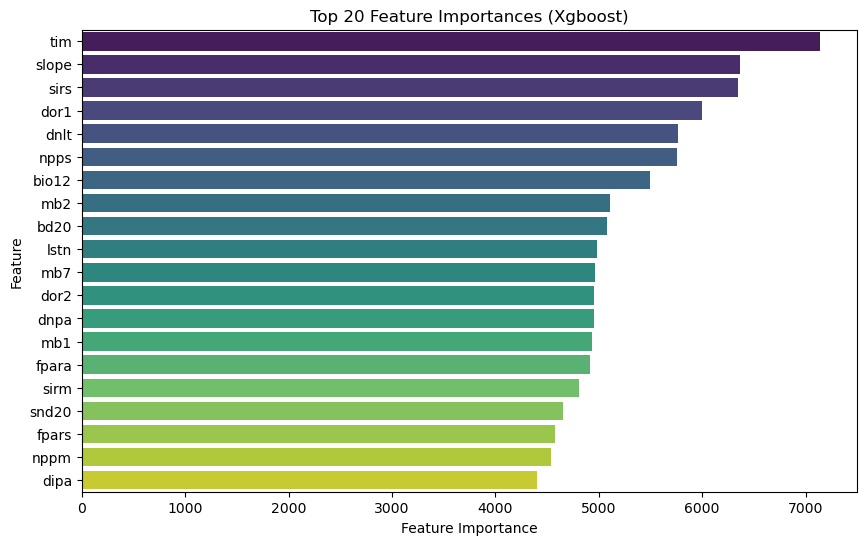

,precision,recall,f1-score,support
>60%,0.650,0.796,0.716,706.000
<30%,0.596,0.615,0.605,439.000
>30%,0.387,0.236,0.293,441.000
accuracy,0.590,0.590,0.590,0.590
macro avg,0.544,0.549,0.538,1586.000
weighted avg,0.562,0.590,0.568,1586.000


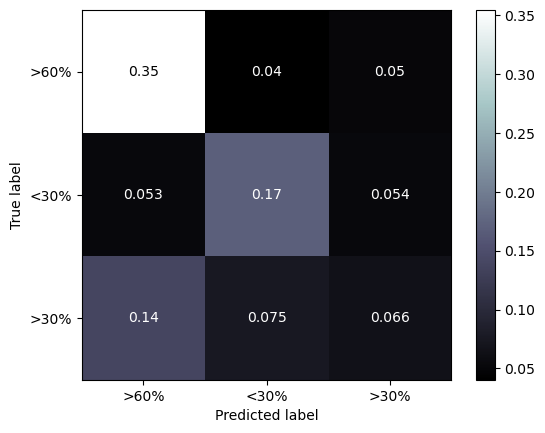

,model_name,best_params,mean_metric,stdev_metric
0,XGBoost,"{'n_estimators': 242, 'max_depth': 10, 'learning_rate': 0.04740696115040889, 'subsample': 0.8184809494967662, 'colsample_bytree': 0.9884981792358092}",0.754,0.005
1,CatBoost,"{'iterations': 204, 'depth': 5, 'learning_rate': 0.15113011665494827}",0.751,0.005
2,LightGBM,"{'n_estimators': 268, 'max_depth': 10, 'learning_rate': 0.1997315407765046, 'subsample': 0.8730723996741286, 'colsample_bytree': 0.7349155333837307}",0.742,0.003


In [47]:
models = {
    'XGBoost': 'xgb',
    'CatBoost': 'cb',
    'LightGBM': 'lgbm'
}

results_df_wcover = evaluate_models(models, X, y_wcover, wcover_labels)
display(results_df_wcover)

results_df_wcover.to_csv('model_tuning_results.csv', index=False)

In [ ]:
results_df_buildings.sort_values('mean_metric')

,model_name,best_params,mean_metric,stdev_metric
2,LightGBM,"{'n_estimators': 279, 'max_depth': 10, 'learning_rate': 0.23671681052039267, 'subsample': 0.629071550556891, 'colsample_bytree': 0.6626381576217053}",0.818,0.000
1,XGBoost,"{'n_estimators': 226, 'max_depth': 6, 'learning_rate': 0.22855978600115687, 'subsample': 0.7830461642593921, 'colsample_bytree': 0.806592284989002}",0.820,0.003
0,CatBoost,"{'iterations': 172, 'depth': 4, 'learning_rate': 0.0269755249000247}",0.826,0.005


In [ ]:
# Predict for each target
buildings_pred = train_best_model_and_predict(X, y_buildings, test, results_df_buildings)
cropland_pred = train_best_model_and_predict(X, y_cropland, test, results_df_cropland)
wcover_pred = train_best_model_and_predict(X, y_wcover, test, results_df_wcover)

,model_name,best_params,mean_metric,stdev_metric
0,CatBoost,"{'iterations': 172, 'depth': 4, 'learning_rate': 0.0269755249000247}",0.826,0.005
1,XGBoost,"{'n_estimators': 226, 'max_depth': 6, 'learning_rate': 0.22855978600115687, 'subsample': 0.7830461642593921, 'colsample_bytree': 0.806592284989002}",0.820,0.003
2,LightGBM,"{'n_estimators': 279, 'max_depth': 10, 'learning_rate': 0.23671681052039267, 'subsample': 0.629071550556891, 'colsample_bytree': 0.6626381576217053}",0.818,0.000


Best model: CatBoost


,model_name,best_params,mean_metric,stdev_metric
0,CatBoost,"{'iterations': 288, 'depth': 10, 'learning_rate': 0.020443766056386536}",0.836,0.007
1,LightGBM,"{'n_estimators': 184, 'max_depth': 9, 'learning_rate': 0.014449984737046485, 'subsample': 0.7185387525407548, 'colsample_bytree': 0.6120847328077912}",0.833,0.002
2,XGBoost,"{'n_estimators': 286, 'max_depth': 4, 'learning_rate': 0.11768684966256975, 'subsample': 0.7672097704788526, 'colsample_bytree': 0.9861197051249365}",0.833,0.004


Best model: CatBoost


,model_name,best_params,mean_metric,stdev_metric
0,CatBoost,"{'iterations': 198, 'depth': 5, 'learning_rate': 0.11224271636159713}",0.753,0.000
1,LightGBM,"{'n_estimators': 233, 'max_depth': 3, 'learning_rate': 0.03470224497297546, 'subsample': 0.7848458242664511, 'colsample_bytree': 0.625205050109305}",0.748,0.003
2,XGBoost,"{'n_estimators': 170, 'max_depth': 8, 'learning_rate': 0.15179656281113063, 'subsample': 0.7249137151443877, 'colsample_bytree': 0.6973643024391176}",0.747,0.002


Best model: CatBoost


In [ ]:
ss['building_prob'] = buildings_pred
ss['cropland_prob'] = cropland_pred
ss['wcover_prob'] = wcover_pred

In [ ]:
ss.head()

,subid,building_prob,cropland_prob,wcover_prob
0,1548905,0.052,0.510,0.111
1,1548829,0.103,0.186,0.211
2,1548811,0.066,0.047,0.111
3,1548806,0.090,0.681,0.143
4,1548798,0.053,0.811,0.265


In [ ]:
ss.to_csv('predictions.csv', index=False)